# Example of CNN Siamese for Fashion MNIST dataset (2)

This notebook will show the main power of Siamese Networks : the ability to generate to new classes without having seen any example of these classes !

For this experiment I will filter both training and testing such that they do not have the same labels. During training, the validation metrics will then show the metrics on completely unseen labels !

Note : this experiment is based on `Fashion MNIST` which has only 10 classes. The results are quite poor but still interesting to analyze

A better experiment with far better results will be provided with the `AudioSiamese` architecture with much bigger datasets

## Imports + model initialization

In [1]:
import pandas as pd
import tensorflow as tf

from utils import plot, plot_multiple, set_display_options, sample_df, filter_df
from datasets import get_dataset, prepare_dataset, test_dataset_time
from models.siamese import ImageSiamese

set_display_options()

input_shape = (28,28,1)
model_name = 'fashionn_mnist_siamese_2'

In [ ]:
model = ImageSiamese(input_shape, normalize = False, nom = model_name)

print(model)

## Model instanciation + dataset loading

In [2]:
model = ImageSiamese(nom = model_name)

model.compile()

print(model)
model.summary()
model.encoder.summary()

Model restoration...
Initializing submodel : siamese !
Optimizer 'siamese_optimizer' initilized successfully !
Submodel siamese compiled !
  Loss : {'reduction': 'auto', 'name': 'binary_crossentropy', 'from_logits': False, 'label_smoothing': 0}
  Optimizer : {'name': 'Adam', 'learning_rate': 0.0010000000474974513, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'epsilon': 1e-07, 'amsgrad': False}
  Metrics : [{'name': 'binary_accuracy', 'dtype': 'float32', 'threshold': 0.5}, {'name': 'EER', 'dtype': 'float32', 'num_thresholds': 200, 'curve': 'ROC', 'summation_method': 'interpolation', 'thresholds': [0.005025125628140704, 0.010050251256281407, 0.01507537688442211, 0.020100502512562814, 0.02512562814070352, 0.03015075376884422, 0.035175879396984924, 0.04020100502512563, 0.04522613065326633, 0.05025125628140704, 0.05527638190954774, 0.06030150753768844, 0.06532663316582915, 0.07035175879396985, 0.07537688442211055, 0.08040201005025126, 0.08542713567839195, 0.0904

In [9]:
def to_pandas(ds):
    return pd.DataFrame([
        {'id' : sample['label'].numpy(), 'image' : sample['image'].numpy()}
        for sample in ds
    ])

ds = get_dataset('fashion_mnist')

full_train, full_valid = to_pandas(ds['train']), to_pandas(ds['test'])

train = filter_df(full_train, id = list(range(7)))
valid = filter_df(full_valid, id = list(range(7, 10)))
valid_seen = filter_df(full_valid, id = list(range(7)))

print("Train size : {} - Valid size : {}".format(len(train), len(valid)))
print("Ids in training set : {} - Ids in validation set : {}".format(
    sorted(train['id'].unique()), sorted(valid['id'].unique())
))

Train size : 42000 - Valid size : 3000
Ids in training set : [0, 1, 2, 3, 4, 5, 6] - Ids in validation set : [7, 8, 9]


## Training + history analysis

In [5]:
model.train(
    train, validation_data = valid,
    epochs = 25, batch_size = 32, pred_step = 2500,
    augment_prct = 0.25, max_by_id = 5000
)

Training config :
HParams :
- augment_prct	: 0.25
- epochs	: 25
- batch_size	: 32
- valid_batch_size	: 32
- test_batch_size	: 1
- verbose	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: 2500
- shuffle_size	: 1024

Epoch 1/25
   1092/Unknown - 10s 9ms/step - loss: 0.5497 - siamese_BinaryAccuracy: 0.6602 - EER: 0.1912 - AUC: 0.8460
Saving after 1 hour training !
1094/1094 [==============================] - 13s 12ms/step - loss: 0.5496 - siamese_BinaryAccuracy: 0.6605 - EER: 0.1911 - AUC: 0.8461 - val_loss: 0.4995 - val_siamese_BinaryAccuracy: 0.7395 - val_EER: 0.3028 - val_AUC: 0.8015
Epoch 2/25
1092/1094 [============================>.] - ETA: 0s - loss: 0.3913 - siamese_BinaryAccuracy: 0.8494 - EER: 0.1417 - AUC: 0.9278
Saving at epoch 1 !
1094/1094 [==============================] - 12s 11ms/step - loss: 0.3913 - siamese_BinaryAccuracy: 0.8495 - EER: 0.1417 - AUC: 0.9278 - val_loss: 0.4946 - val_siamese_BinaryAccuracy: 0.7677 - val_EER: 0.3044 - val_AUC: 0.78

===== History =====
        loss  siamese_BinaryAccuracy       EER       AUC  val_loss  val_siamese_BinaryAccuracy   val_EER  \
0   0.492286                0.754523  0.191114  0.885815  0.499525                    0.739539  0.302767   
1   0.370454                0.857975  0.141671  0.933935  0.494610                    0.767735  0.304433   
2   0.308603                0.881598  0.120071  0.950814  0.511515                    0.778207  0.292100   
3   0.269626                0.895705  0.106257  0.960053  0.578701                    0.770611  0.307867   
4   0.241456                0.906640  0.095143  0.966958  0.619759                    0.765236  0.310633   
5   0.219336                0.914839  0.085814  0.971969  0.629020                    0.776941  0.302133   
6   0.201707                0.921370  0.080000  0.975758  0.667383                    0.763582  0.300967   
7   0.187085                0.927769  0.073229  0.978931  0.684101                    0.768301  0.294333   
8   0.17

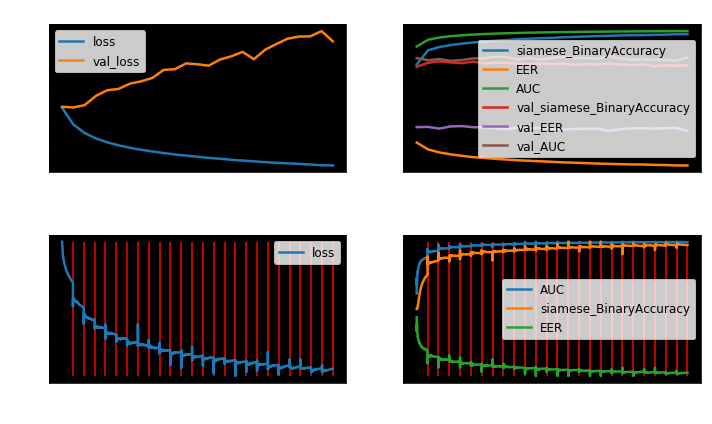

In [6]:
print(model.history)
model.plot_history()

## Embeddings

Here we can see embeddings on seen and unseen labels (both on the validation set so unsee datas). 

We can notice that for unseen labels, it seems to have 2 labels not well separated but 1 clearly different (explaination in the `prediction` section)

The same behaviour append for seen labels where some are quite close even though clearly better separated. 

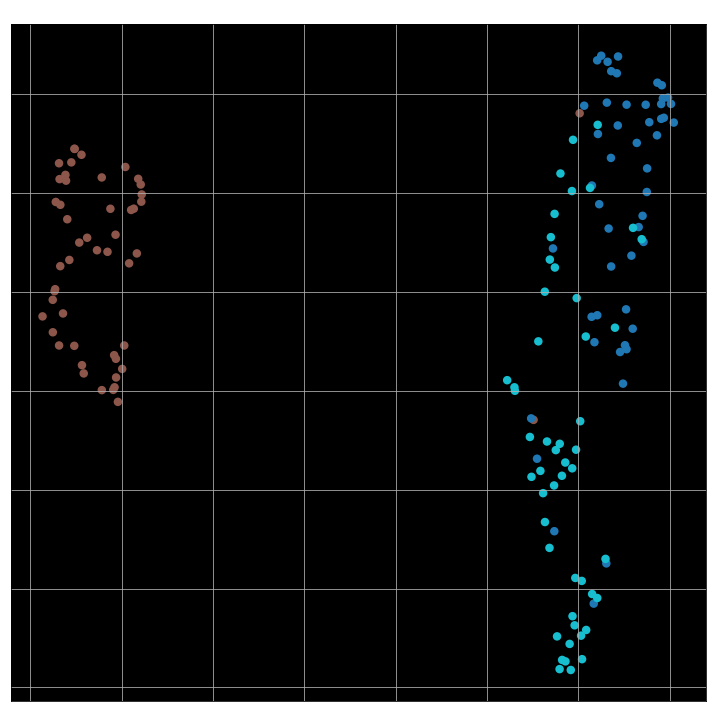

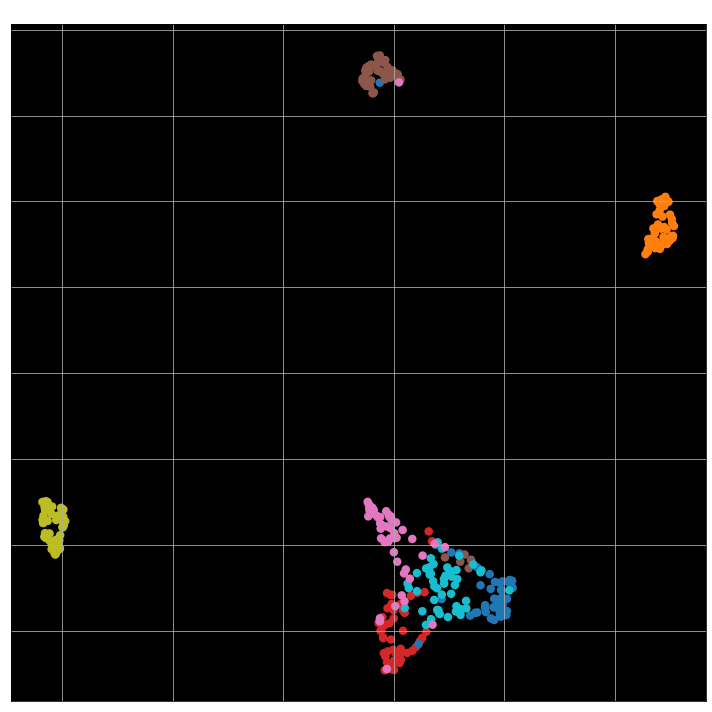

In [10]:
valid_datas = sample_df(valid, n = 3, n_sample = 50)

model.plot_embedding(valid_datas, title = "Embeddings for unseen labels")

train_datas = sample_df(valid_seen, n = 7, n_sample = 50)
model.plot_embedding(train_datas, title = "Embeddings for seen labels")


## Prediction

Reminder : by default the model computes a distance-score and not a similarity score. It means that the score on pictures is the probability to belong to different class. 

We can see that the model has somme trouble to distinguish `sneakers` and `ankle boot` while `bag` is well identified. Note thatin the 7th first labels, there is only `sandal` which is close to these labels so it can be comprehensible the model has trouble to separate those 2 labels

Maybe an interesting test could be to put as unseen labels 3 labels more different such as `sandal`, `shirt` and `bag` (5, 6 and 8)

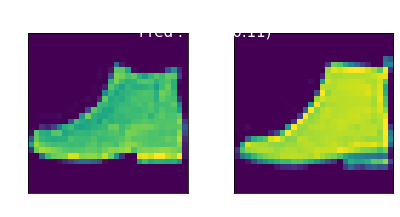

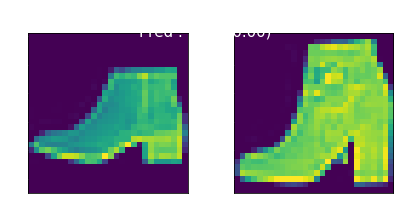

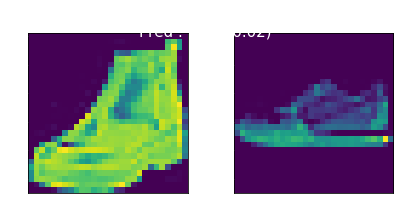

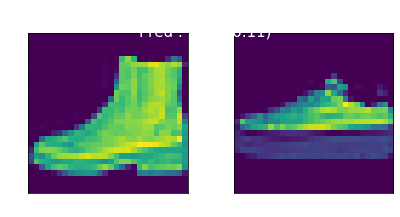

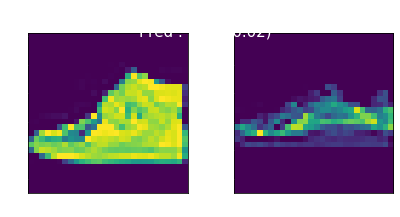

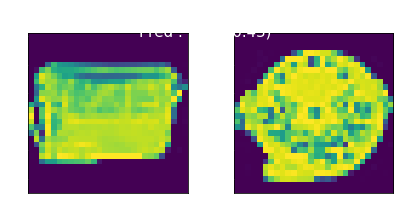

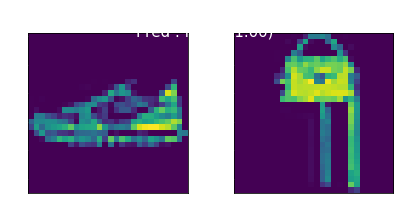

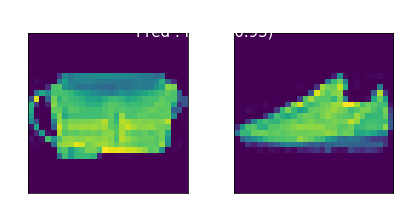

In [8]:
config = model.get_dataset_config(is_validation = True, batch_size = 2)

ds_train = prepare_dataset(valid, ** config)

n = 2
for i, (inputs, target) in enumerate(ds_train):
    if i >= n: break
    
    x, y = inputs
    
    scores = tf.squeeze(model(inputs))
    pred = model.decode_output(scores)
    target = model.decode_output(tf.cast(target, tf.float32))
    
    data = {}
    for i, (xi, yi, ti, si, pi) in enumerate(zip(x, y, target, scores, pred)):
        plot_multiple(
            input_x = xi, input_y = yi, plot_type = 'imshow', size = 3,
            title = 'Same : {}\nPred : {} ({:.2f})'.format(ti, pi, float(si))
        )
